This notebook steps through the creation of the graph to use for comparing accessibility between the generated and actual bus stops.

In [188]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import route_planning.helpers.route_planning_helper as rp_helper
import testing.helpers.testing_helper as test_helper
import config

Get a graph of Donegal that has all roads, walkways etc

In [189]:
G_all_donegal = ox.graph_from_place("Donegal, Ireland", network_type="all")
ox.save_graphml(G_all_donegal, filepath=f"{config.testing_graphml_path}/testing_graph.graphml")


#G_all_donegal = ox.load_graphml(filepath=f"{config.testing_graphml_path}/testing_graph.graphml")

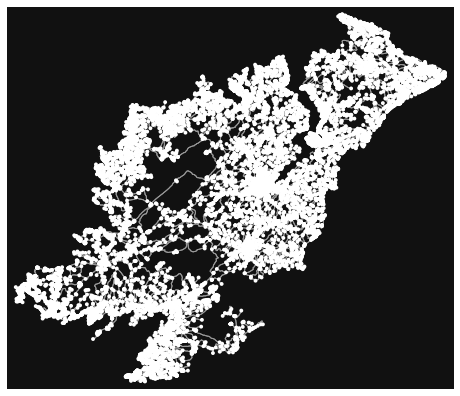

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f257a300160>)

In [190]:
ox.plot_graph(G_all_donegal)

Load the graph with labelled bus stops

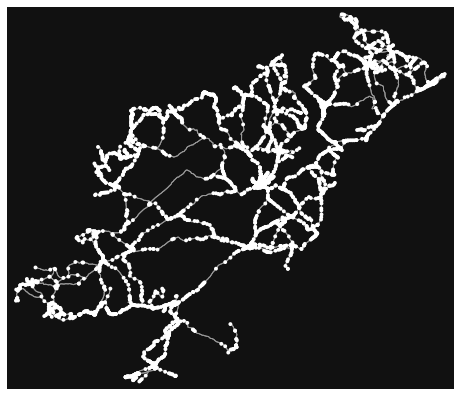

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2585666f40>)

In [191]:
G_with_routes = ox.load_graphml(filepath=f"{config.testing_graphml_path}/actual_routes_added.graphml")
ox.plot_graph(G_with_routes)

Merge routes data into the testing graph

Convert test graph to nodes/edges dataframes

In [192]:
test_nodes, test_edges = ox.graph_to_gdfs(G_all_donegal)
len(test_nodes)

24742

And the same for the original graph

In [193]:
route_nodes, route_edges = ox.graph_to_gdfs(G_with_routes)
bool_replace = {"True": True, "False": False}
route_nodes["community_route"] = route_nodes["community_route"].map(bool_replace).fillna(False)
route_nodes["actual_stop"] = route_nodes["actual_stop"].map(bool_replace).fillna(False)

len(route_nodes)

3579

In [194]:
actual_stop_nodes = route_nodes[route_nodes["actual_stop"]]["osmid"].tolist()
len(actual_stop_nodes)

122

Join the route graph nodes with the test graph nodes

In [195]:
merged_nodes = gpd.sjoin(test_nodes, route_nodes,
                         how="left", op="intersects")
len(merged_nodes)

24742

In [196]:
merged_nodes.head()

,y_left,x_left,osmid_left,highway_left,geometry,index_right,y_right,x_right,osmid_right,community,rank,top_n,route_flag,community_route,community_route_order,connection,connection_order,actual_stop,actual_route_order,highway_right
2907242498,54.865236,-7.508191,2907242498,NaN,POINT (-7.50819 54.86524),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
780664835,54.972684,-7.709056,780664835,NaN,POINT (-7.70906 54.97268),7.806648e+08,54.972684,-7.709056,7.806648e+08,10,0.0002789561526694481,0,0,False,-1,None,-1,False,NaN,NaN
2114650125,55.036243,-7.383424,2114650125,NaN,POINT (-7.38342 55.03624),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3778150429,54.852483,-7.525723,3778150429,NaN,POINT (-7.52572 54.85248),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1417674781,55.225775,-7.085802,1417674781,NaN,POINT (-7.08580 55.22577),1.417675e+09,55.225775,-7.085802,1.417675e+09,1,0.00020443990694311745,0,0,False,101,None,99,False,NaN,NaN


Remove duplicate columns introduced in merge, these are all default values

In [197]:
merged_nodes = merged_nodes.loc[:,~merged_nodes.columns.str.endswith("_right")]
merged_nodes.head()

,y_left,x_left,osmid_left,highway_left,geometry,community,rank,top_n,route_flag,community_route,community_route_order,connection,connection_order,actual_stop,actual_route_order
2907242498,54.865236,-7.508191,2907242498,NaN,POINT (-7.50819 54.86524),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
780664835,54.972684,-7.709056,780664835,NaN,POINT (-7.70906 54.97268),10,0.0002789561526694481,0,0,False,-1,None,-1,False,NaN
2114650125,55.036243,-7.383424,2114650125,NaN,POINT (-7.38342 55.03624),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3778150429,54.852483,-7.525723,3778150429,NaN,POINT (-7.52572 54.85248),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1417674781,55.225775,-7.085802,1417674781,NaN,POINT (-7.08580 55.22577),1,0.00020443990694311745,0,0,False,101,None,99,False,NaN


Remove "_left" from remaining column names

In [198]:
merged_nodes.columns = [col.replace("_left", "") for col in merged_nodes.columns]
merged_nodes.head()

,y,x,osmid,highway,geometry,community,rank,top_n,route_flag,community_route,community_route_order,connection,connection_order,actual_stop,actual_route_order
2907242498,54.865236,-7.508191,2907242498,NaN,POINT (-7.50819 54.86524),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
780664835,54.972684,-7.709056,780664835,NaN,POINT (-7.70906 54.97268),10,0.0002789561526694481,0,0,False,-1,None,-1,False,NaN
2114650125,55.036243,-7.383424,2114650125,NaN,POINT (-7.38342 55.03624),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3778150429,54.852483,-7.525723,3778150429,NaN,POINT (-7.52572 54.85248),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1417674781,55.225775,-7.085802,1417674781,NaN,POINT (-7.08580 55.22577),1,0.00020443990694311745,0,0,False,101,None,99,False,NaN


Check that all "actual" stops are present

In [199]:
merged_actual_stop_nodes = merged_nodes[merged_nodes["actual_stop"] == True]["osmid"].tolist()
len(merged_actual_stop_nodes)

119

119 found, expecting 122. Find the 3 missing nodes:

In [200]:
diff = set(actual_stop_nodes).difference(merged_actual_stop_nodes)
diff

{258453072, 320673554, 2411894191}

In [201]:
merged_nodes.loc[merged_nodes["osmid"].isin(diff)]

,y,x,osmid,highway,geometry,community,rank,top_n,route_flag,community_route,community_route_order,connection,connection_order,actual_stop,actual_route_order
320673554,54.932912,-7.596713,320673554,NaN,POINT (-7.59671 54.93291),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258453072,55.334708,-7.286484,258453072,NaN,POINT (-7.28648 55.33471),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Only 2 of the osm ids were found in merged nodes, update those

In [202]:
merged_nodes.loc[(merged_nodes["osmid"] == 320673554), "actual_stop"] = True
merged_nodes.loc[(merged_nodes["osmid"] == 258453072), "actual_stop"] = True
len(merged_nodes[merged_nodes["actual_stop"] == True]["osmid"])

121

Find the coordinates of the missing node

In [203]:
osm_id = 2411894191
missing_node = route_nodes[route_nodes["osmid"] == osm_id]
missing_node

,y,x,osmid,community,rank,geometry,top_n,route_flag,community_route,community_route_order,connection,connection_order,actual_stop,actual_route_order,highway
2411894191,55.275666,-7.634499,2411894191,3,0.0002717167601549818,POINT (-7.63450 55.27567),0,0,False,-1,None,-1,True,LL7-6,turning_circle


Use those coordinates to find the closest node in graph with all roads included

In [204]:
n = ox.get_nearest_node(G_all_donegal, (missing_node["y"].values[0],
                                        missing_node["x"].values[0]))
n

2385350205

In [205]:
test_edges[test_edges["v"] == n]

,osmid,ref,highway,oneway,length,geometry,name,bridge,lanes,maxspeed,access,width,service,junction,tunnel,area,u,v,key
3307,"[36821991, 230001445, 232879767]",R247,"[service, secondary]",False,818.058,"LINESTRING (-7.63860 55.27311, -7.63858 55.273...",NaN,NaN,NaN,80,permissive,NaN,NaN,NaN,NaN,NaN,6268784624,2385350205,0


Update that node and there should now be 122 actual stop nodes

In [206]:
merged_nodes.loc[(merged_nodes["osmid"] == n), "actual_stop"] = True
len(merged_nodes[merged_nodes["actual_stop"] == True]["osmid"])

122

Check that all generated stops were added

First the connection stops:

In [207]:
connecting_labels = ["a", "b", "c", "d"]
connection_present = merged_nodes["connection"].isin(connecting_labels).value_counts()
connection_present.values[1]

156

2 missing, expecting 158. Now check for community route nodes:

In [208]:
len(merged_nodes[merged_nodes["community_route"] == True])
# 16 missing

523

Expecting 539, so there are 16 missing. Compare with original graph's nodes:

In [209]:
community_route_nodes = route_nodes[route_nodes["community_route"]]["osmid"].tolist()
len(community_route_nodes)

539

In [210]:
merged_community_route_nodes = merged_nodes[merged_nodes["community_route"] == True]["osmid"].tolist()
len(merged_community_route_nodes)

523

In [211]:
diff = set(community_route_nodes).difference(merged_community_route_nodes)
diff

{258438551,
 258466029,
 320660381,
 320673554,
 821215522,
 821222613,
 821234197,
 1417678805,
 1417678858,
 1435314101,
 1435314108,
 1556355680,
 1641061531,
 2111294750,
 2397804385,
 2907774312}

Update the nodes found above

In [212]:
for d in diff:
    merged_nodes.loc[(merged_nodes["osmid"] == d), "community_route"] = True
len(merged_nodes[merged_nodes["community_route"] == True]["osmid"])

539

Now we have the correct number of community stops. Find the missing connecting stops:

In [213]:
route_nodes["connection"].isin(connecting_labels).value_counts().values[1]

158

In [214]:
connection_present.values[1]

156

In [215]:
import itertools
# find the 2 missing connection stops
# get nodes from dataframes
original_connecting_nodes = [route_nodes[
                                    route_nodes["connection"] == label]
                                for label in connecting_labels]
merged_connecting_nodes = [merged_nodes[
                                    merged_nodes["connection"] == label]
                                for label in connecting_labels]

# get a list of osm ids for each set of nodes
original_ids = list(itertools.chain.from_iterable(
    [nodes["osmid"].tolist() for nodes in original_connecting_nodes]))

merged_ids = list(itertools.chain.from_iterable(
    [nodes["osmid"].tolist() for nodes in merged_connecting_nodes]))

In [216]:
# get the difference
diff = set(original_ids).difference(merged_ids)
diff

{1561807693, 2062405413}

Update the 2 different nodes, setting connection route to True rather than a letter as it doesn't matter for test purposes

In [217]:
for d in diff:
    merged_nodes.loc[(merged_nodes["osmid"] == d), "connection"] = True
merged_nodes["connection"].isin(connecting_labels).value_counts().values[1]

156

Update other connection labels to True also

In [218]:
for label in connecting_labels:
    merged_nodes.loc[
        (merged_nodes["connection"] == label), "connection"] = True
len(merged_nodes[merged_nodes["connection"] == True])
# test_edges.head()

158

Now the expected 158 labelled nodes are present, and 650 generated stops in total:

In [219]:
len(merged_nodes[(merged_nodes["community_route"] == True) |
                        (merged_nodes["connection"] == True)])

650

In [222]:
# recreate test graph with route data included
G = ox.graph_from_gdfs(merged_nodes, test_edges)
len(G.nodes)

24742

In [ ]:
ox.save_graphml(G, filepath=f"{config.testing_graphml_path}/merged_routes.graphml")

In [ ]:
Visualise the real and generated bus stop locations

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

nodes, edges = ox.graph_to_gdfs(G)
gen_route_nodes = nodes[(nodes["community_route"] == True) |
                        (merged_nodes["connection"] == True)]
actual_route_nodes = nodes[(nodes["actual_stop"] == True)]


fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_facecolor("black")

plt.rc("legend", fontsize=25,
       facecolor="black")

edges.plot(
    ax=ax,
    edgecolor="grey",
    linewidth=1,
    facecolor="none",
    zorder=1,
    alpha=0.8
)

gen_route_nodes.plot(
    ax=ax,
    marker="o",
    markersize=100,
    zorder=2,
    categorical=True
)

actual_route_nodes.plot(
    ax=ax,
    marker="d",
    markersize=100,
    zorder=2,
    categorical=True
)

In [223]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

nodes, edges = ox.graph_to_gdfs(G)
gen_route_nodes = nodes[(nodes["community_route"] == True) |
                        (merged_nodes["connection"] == True)]
actual_route_nodes = nodes[(nodes["actual_stop"] == True)]


fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_facecolor("black")

plt.rc("legend", fontsize=25,
       facecolor="black")

edges.plot(
    ax=ax,
    edgecolor="grey",
    linewidth=1,
    facecolor="none",
    zorder=1,
    alpha=0.8
)

gen_route_nodes.plot(
    ax=ax,
    marker="o",
    markersize=100,
    zorder=2,
    categorical=True
)

actual_route_nodes.plot(
    ax=ax,
    marker="d",
    markersize=100,
    zorder=2,
    categorical=True
)

Visualise the real and generated bus stop locations

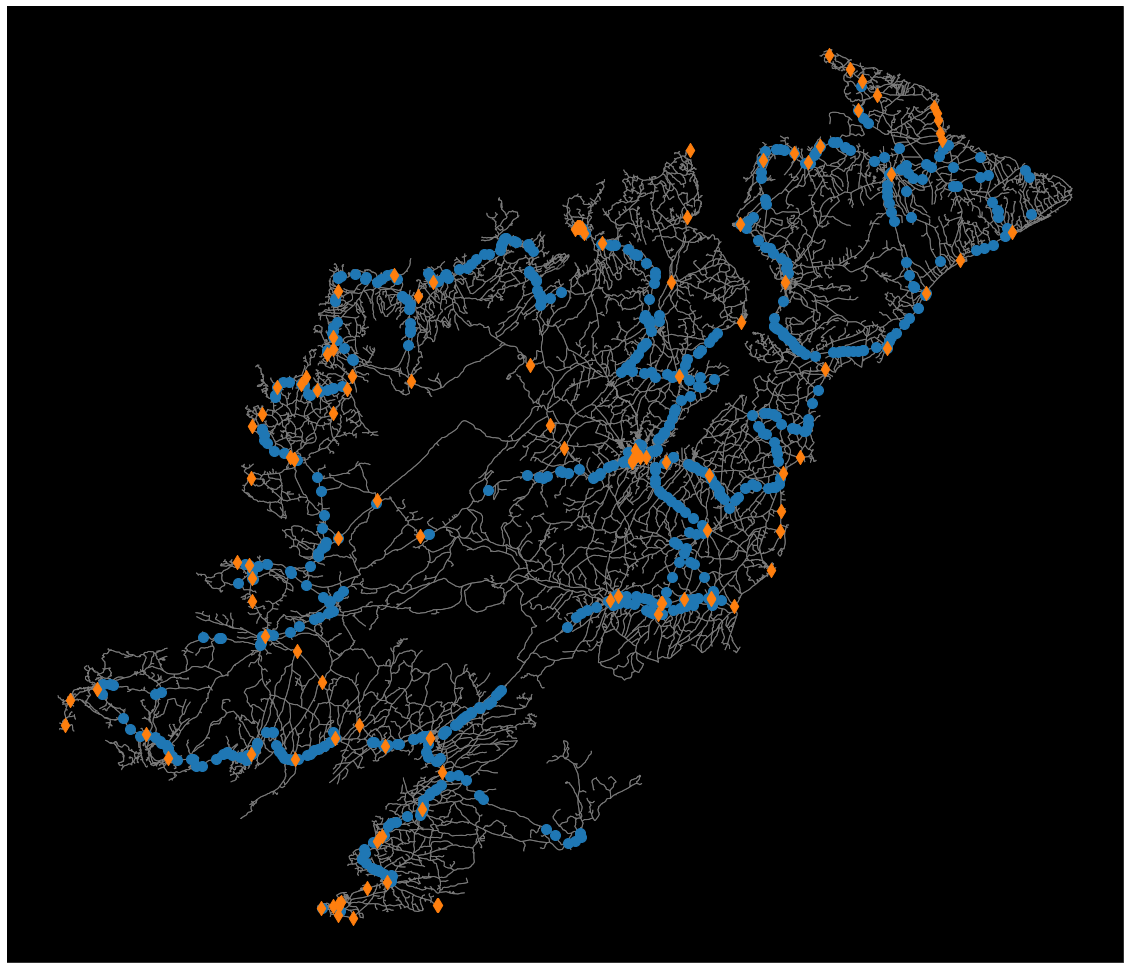

In [224]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

nodes, edges = ox.graph_to_gdfs(G)
gen_route_nodes = nodes[(nodes["community_route"] == True) |
                        (merged_nodes["connection"] == True)]
actual_route_nodes = nodes[(nodes["actual_stop"] == True)]


fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_facecolor("black")

plt.rc("legend", fontsize=25,
       facecolor="black")

edges.plot(
    ax=ax,
    edgecolor="grey",
    linewidth=1,
    facecolor="none",
    zorder=1,
    alpha=0.8
)

gen_route_nodes.plot(
    ax=ax,
    marker="o",
    markersize=100,
    zorder=2,
    categorical=True
)

actual_route_nodes.plot(
    ax=ax,
    marker="d",
    markersize=100,
    zorder=2,
    categorical=True
)